yt : [WARNING  ] 2023-09-27 12:25:41,352 The unbound_particles particle filter already exists. Overriding.
yt : [INFO     ] 2023-09-27 12:25:41,368 Particle file found: def_high_dens_hdf5_chk_000030
yt : [WARNING  ] 2023-09-27 12:25:41,385 Extending theta dimension to 2PI + left edge.
yt : [INFO     ] 2023-09-27 12:25:41,427 Parameters: current_time              = 3.0000116827922714
yt : [INFO     ] 2023-09-27 12:25:41,428 Parameters: domain_dimensions         = [ 64 128   1]
yt : [INFO     ] 2023-09-27 12:25:41,429 Parameters: domain_left_edge          = [ 0.00000e+00 -1.31072e+10  0.00000e+00]
yt : [INFO     ] 2023-09-27 12:25:41,429 Parameters: domain_right_edge         = [1.31072000e+10 1.31072000e+10 6.28318531e+00]
yt : [INFO     ] 2023-09-27 12:25:41,430 Parameters: cosmological_simulation   = 0


YTCutRegion (def_high_dens_hdf5_chk_000030): , base_object=YTRegion (def_high_dens_hdf5_chk_000030): , center=[6.55360000e+09 0.00000000e+00 3.14159265e+00] cm, left_edge=[ 0.00000e+00 -1.31072e+10  0.00000e+00] cm, right_edge=[1.31072000e+10 1.31072000e+10 6.28318531e+00] cm, conditionals=['obj["flash", "bneg"] > 1.0e17', 'obj["gas", "density"] > 1.0e-2']
('all', 'mesh_id')
('all', 'particle_blk')
('all', 'particle_dens')
('all', 'particle_eint')
('all', 'particle_flam')
('all', 'particle_gpot')
('all', 'particle_gravitational_potential')
('all', 'particle_index')
('all', 'particle_ones')
('all', 'particle_phaq')
('all', 'particle_phfa')
('all', 'particle_phqn')
('all', 'particle_position')
('all', 'particle_position_cylindrical_radius')
('all', 'particle_position_cylindrical_theta')
('all', 'particle_position_cylindrical_z')
('all', 'particle_position_relative_x')
('all', 'particle_position_relative_y')
('all', 'particle_position_relative_z')
('all', 'particle_position_spherical_phi'

yt : [INFO     ] 2023-09-27 12:25:46,999 xlim = -5743600000.000000 7363600000.000000
yt : [INFO     ] 2023-09-27 12:25:47,000 ylim = -13107200000.000000 13107200000.000000
yt : [INFO     ] 2023-09-27 12:25:47,000 Setting origin='native' for cylindrical geometry.
yt : [INFO     ] 2023-09-27 12:25:47,001 xlim = -5743600000.000000 7363600000.000000
yt : [INFO     ] 2023-09-27 12:25:47,001 ylim = -13107200000.000000 13107200000.000000
yt : [INFO     ] 2023-09-27 12:25:47,005 Making a fixed resolution buffer of (('flash', 'ye  ')) 800 by 800
yt : [INFO     ] 2023-09-27 12:25:48,587 xlim = -5743600000.000000 7363600000.000000
yt : [INFO     ] 2023-09-27 12:25:48,587 ylim = -13107200000.000000 13107200000.000000
yt : [INFO     ] 2023-09-27 12:25:48,588 Setting origin='native' for cylindrical geometry.
yt : [INFO     ] 2023-09-27 12:25:48,588 xlim = -5743600000.000000 7363600000.000000
yt : [INFO     ] 2023-09-27 12:25:48,589 ylim = -13107200000.000000 13107200000.000000
yt : [INFO     ] 2023-

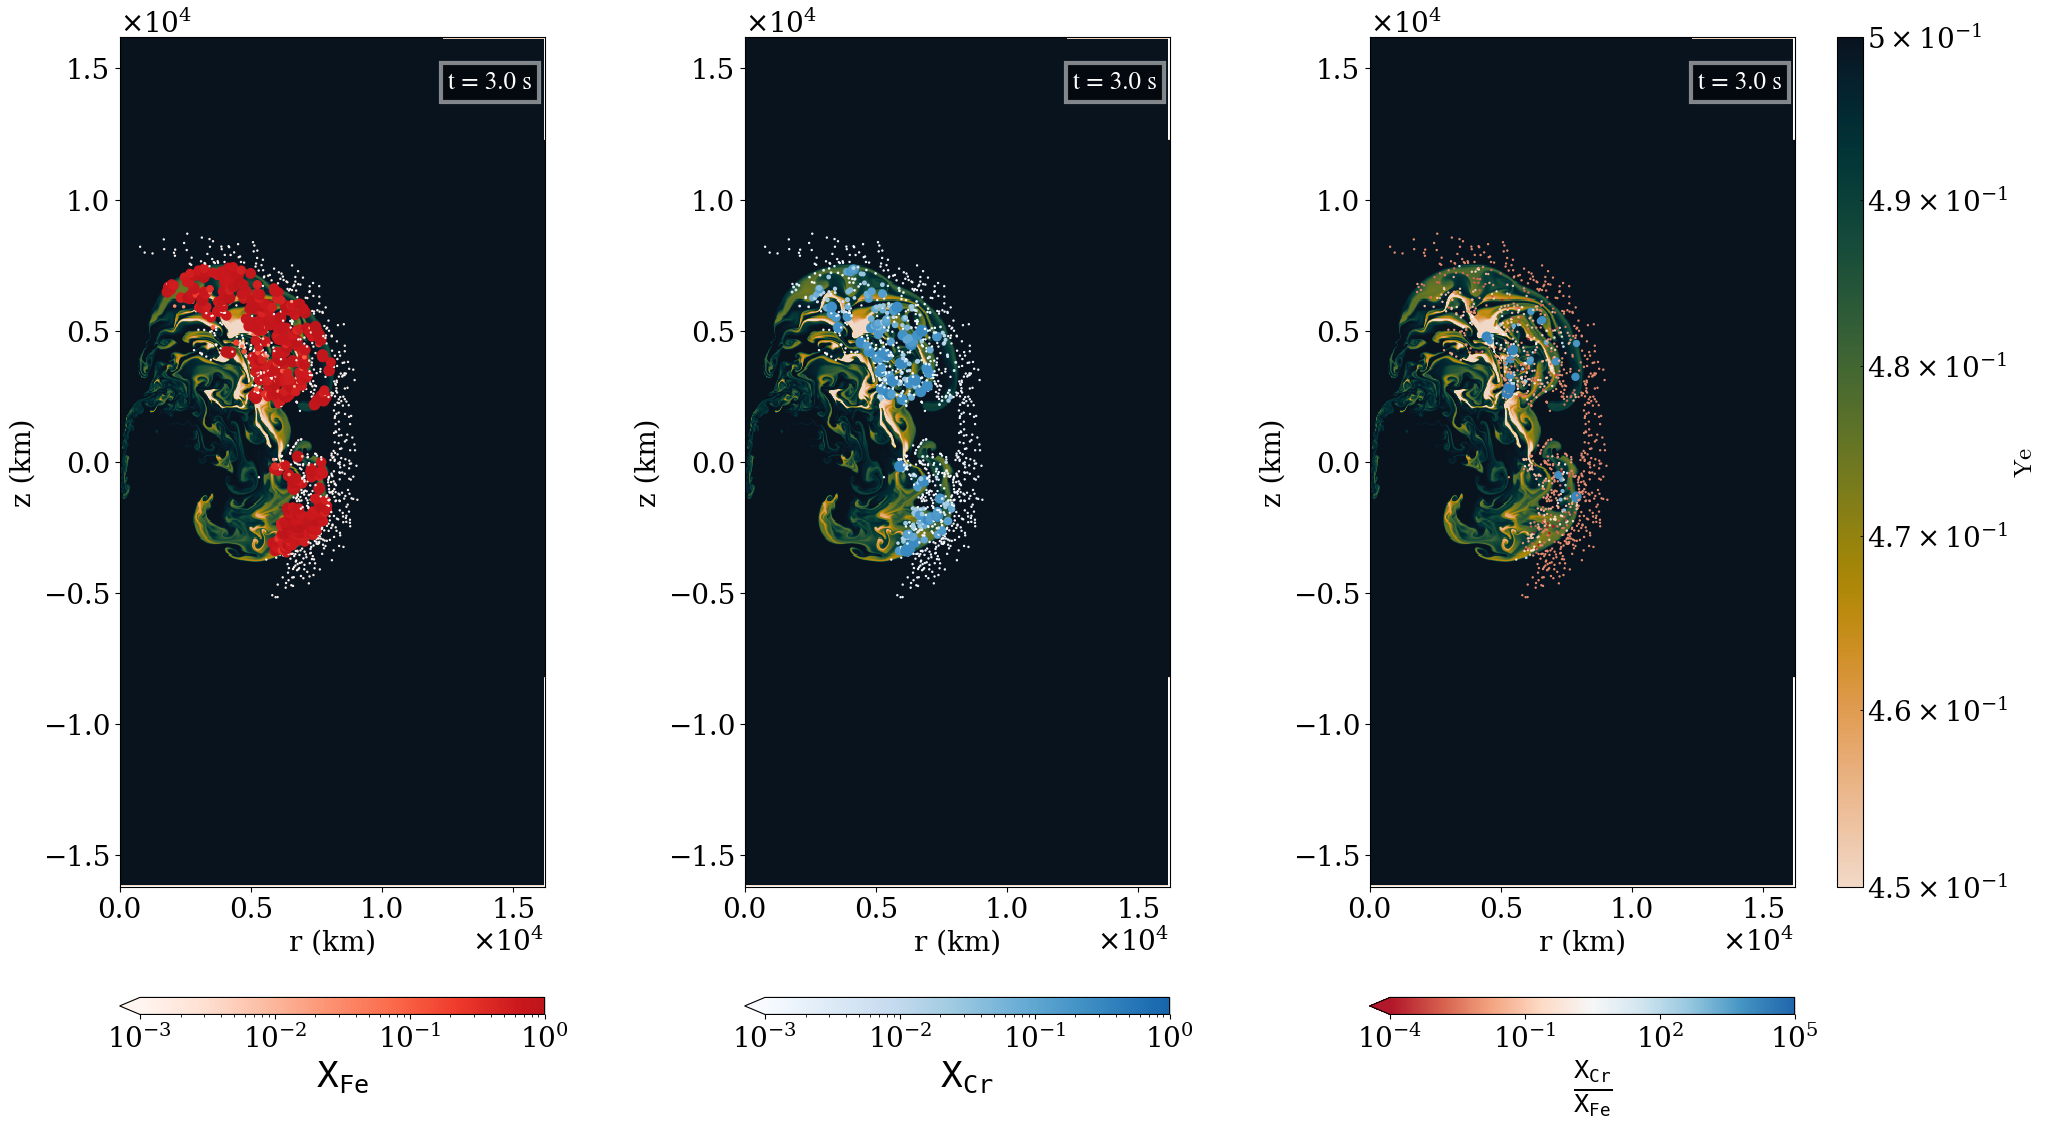

In [27]:
import yt
import glob
import mpi4py
from unyt import unyt_array
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.tri as tri
import matplotlib.ticker as ticker
import seaborn as sns
import cmasher as cmr
import cmocean 

mpl_cmap = cmr.get_sub_cmap('cmr.savanna_r',0.10, 0.90)
rd_bu_cmap = cmr.get_sub_cmap('RdBu',0.1,0.9)
Bu_cmap = cmr.get_sub_cmap('Blues',0.0,0.80)
Rd_cmap = cmr.get_sub_cmap('Reds',0.0,0.80)

#mpl_cmap =plt.get_cmap('cmr.bubblegum_r')
#mpl_cmap = cmocean.cm.haline_r
class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

plt.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.sans-serif'] = ['Times']
plt.rcParams['font.size'] = 20

cent = 8.1e8

files = glob.glob ("def_high_dens_hdf5_chk_000030")
files.sort()

tag_file = pd.read_csv("../HIGH_DEN_DEF_21/part_IGEs_Ti_HCD_PD_Z_0p0.dat", sep = "\s+", usecols = [0, 1, 4, 5, 6, 7], 
                       names = ["p_tag", "Fe", "Cr", "Ti", "Cr/Fe", "Ti/Fe"])

tags = tag_file["p_tag"].to_numpy()

def unbound_particles(pfilter,data):
    p_tags = data[(pfilter.filtered_type, "particle_tag")]
    clumps = np.in1d(p_tags, tags)
    return yt.YTArray(clumps)
    
yt.add_particle_filter("unbound_particles", function = unbound_particles, filtered_type = "all", requires = ["particle_tag"])


for file in files:
    ds = yt.load(file)
    
###########===============================functions begins here=====================================##############    

    def binding_energy(field, data):
        return(((0.5 * ((data[("flash", "velx")])**2 + (data[("flash", "vely")])**2)) + 
                data[("flash", "eint")] + data[("flash", "gpot")]))

    ds.add_field(("flash", "bneg"), 
                 function = binding_energy, 
                 sampling_type = "cell", 
                 units = "auto")
    
    ds.add_particle_filter("unbound_particles")
    
    def X_iron(field,data):
        A = data[("unbound_particles", "particle_tag")]
        A = A.tolist()
        filtered_X_fe = tag_file
        #filtered_X_fe["Fe"] = filtered_X_fe["Fe"].where(filtered_X_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_fe.loc[filtered_X_fe['p_tag'].isin(A)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[i for i, x in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda x: A.index(x[1]))], :]
        arr_x = filtered_p_tag["Fe"].to_numpy()
        X_fe = unyt_array(arr_x, "dimensionless")
        return (X_fe)
    
    ds.add_field(("unbound_particles", "X_fe"), function = X_iron, sampling_type = "particle", units = 'dimensionless')
    #ds.add_deposited_particle_field(("unbound_particles", "X_fe"),'nearest', weight_field = "particle_ones",kernel_name = "cubic")
    
    
    def X_chromium(field, data):
        B = data[("unbound_particles", "particle_tag")]
        B = B.tolist()
        filtered_X_cr = tag_file
        #filtered_X_cr["Cr"] = filtered_X_cr["Cr"].where(filtered_X_cr["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr.loc[filtered_X_cr['p_tag'].isin(B)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[j for j, y in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda y: B.index(y[1]))], :]
        arr_y = filtered_p_tag["Cr"].to_numpy()
        X_cr = unyt_array(arr_y, "dimensionless")
        return X_cr
    
    
    ds.add_field(("unbound_particles", "X_cr"), function = X_chromium, sampling_type = "particle", units = 'dimensionless')
    
    def X_titanium(field, data):
        B = data[("unbound_particles", "particle_tag")]
        B = B.tolist()
        filtered_X_cr = tag_file
        #filtered_X_cr["Ti"] = filtered_X_cr["Ti"].where(filtered_X_cr["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr.loc[filtered_X_cr['p_tag'].isin(B)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[j for j, y in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda y: B.index(y[1]))], :]
        arr_y = filtered_p_tag["Ti"].to_numpy()
        X_ti = unyt_array(arr_y, "dimensionless")
        return X_ti
    
    
    ds.add_field(("unbound_particles", "X_ti"), function = X_titanium, sampling_type = "particle", units = 'dimensionless')
    
    #ds.add_deposited_particle_field(("unbound_particles","X_cr"), "nearest", weight_field = "particle_ones")
    
    def X_Cr_to_Fe(field,data):
        C = data[("unbound_particles", "particle_tag")]
        C = C.tolist()
        filtered_X_cr_fe = tag_file
        #filtered_X_cr_fe["Cr/Fe"] = filtered_X_cr_fe["Cr/Fe"].where(filtered_X_cr_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr_fe.loc[filtered_X_cr_fe['p_tag'].isin(C)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[k for k, z in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda z: C.index(z[1]))], :]
        arr_z = filtered_p_tag["Cr/Fe"].to_numpy()
        X_ti_fe = unyt_array(arr_z, "dimensionless")
        return X_ti_fe
    
    ds.add_field(("unbound_particles", "X_Cr/Fe"), function = X_Cr_to_Fe, sampling_type = "particle", units = "dimensionless")
    
    def X_Ti_to_Fe(field,data):
        C = data[("unbound_particles", "particle_tag")]
        C = C.tolist()
        filtered_X_cr_fe = tag_file
        #filtered_X_cr_fe["Cr/Fe"] = filtered_X_cr_fe["Cr/Fe"].where(filtered_X_cr_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr_fe.loc[filtered_X_cr_fe['p_tag'].isin(C)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[k for k, z in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda z: C.index(z[1]))], :]
        arr_z = filtered_p_tag["Ti/Fe"].to_numpy()
        X_cr_fe = unyt_array(arr_z, "dimensionless")
        return X_cr_fe
    
    ds.add_field(("unbound_particles", "X_Ti/Fe"), function = X_Ti_to_Fe, sampling_type = "particle", units = "dimensionless")
    
    #ds.add_deposited_particle_field(("unbound_particles", "X_Cr/Fe"), "nearest", weight_field = "particle_ones")
    
    def part_pos_r(field, data):
        return (data["unbound_particles", "particle_posx"])
    ds.add_field(("unbound_particles", "particle_position_r"), function = part_pos_r, sampling_type = "particle", units = "auto")
    
    def part_pos_z(field, data):
        return (data["unbound_particles", "particle_posy"])
    ds.add_field(("unbound_particles", "particle_position_z"), function = part_pos_z, sampling_type = "particle", units = "auto", force_override = True)
    
###########===============================functions ends here=====================================##############
    
    fig = plt.figure()

    grid = AxesGrid(fig,rect = (0.075, 0.075, 3, 1),
                    nrows_ncols = (1, 3),
                    axes_pad= 2.0,
                    label_mode="2",
                    share_all = True,
                    cbar_location = "right",
                    cbar_mode = "single",
                    cbar_size = "6%",
                    cbar_pad = "10%")
    
    ad = ds.all_data()
    box = ds.region(center = [cent,0,0], left_edge = [0,-2*cent,0], right_edge = [2*cent,2*cent,2*cent])
    #A_G = ds.arbitrary_grid(left_edge = [0.0,-2*cent,0.0], right_edge = [2*cent,2*cent,2*cent], dims = [512, 1024, 8])
    #sc = ds.smoothed_covering_grid(level = 9, left_edge = [0,-13107200000.0,0], dims = ds.domain_dimensions , num_ghost_zones=0)
    #print(box[("deposit", "unbound_particles_nn_X_fe")])
    #fn = box.save_as_dataset(fields = [("deposit", "unbound_particles_nn_X_fe")])
    #bg = yt.load()
    
    positive_binding_energy = ad.cut_region(['obj["flash", "bneg"] > 1.0e17'])
    negative_binding_energy = ad.cut_region(['obj["flash", "bneg"] < -1.0e17'])
    pos_bn_eg_without_fluff = positive_binding_energy.cut_region(['obj["gas", "density"] > 1.0e-2'])
    neg_bn_eg_wihtout_fluff = negative_binding_energy.cut_region(['obj["gas", "density"] > 1.0e-2'])
    bneg_new = ad.exclude_inside(("flash", "bneg"), -1.0e17, 1.0e17)
    bn_eg_without_fluff = bneg_new.exclude_below(("gas", "density"), 1.0e-2)
    
    print(pos_bn_eg_without_fluff)
    
    for field in ds.derived_field_list:
        print(field)
    #print(ad['flash','r'])
    
    slc1 = yt.SlicePlot(ds, 'theta', ('flash', 'ye  '), center=[cent,0,0], data_source = box)
    slc1.set_zlim(('flash', 'ye  '), 0.45, 0.5)
    #slc1.set_log(('flash', 'bneg'), linthresh = 1.0e17)
    slc1.set_cmap (field = ('flash', 'ye  '), cmap = mpl_cmap)
    #slc1.annotate_particles(width = (4*cent, "cm"), p_size=5.0, col='k', marker='o', ptype='unbound_particles',alpha=1.0)
    #slc1.annotate_title("Density Plot with 'Iron' clumps in contours")
    #slc1.annotate_contour(field = ('deposit', 'unbound_particles_nn_X_fe'),levels = 3,take_log = False ,plot_args = {"colors":"red", "linewidths": 0.5})
    slc1.annotate_timestamp (corner='upper_right', draw_inset_box=True, redshift = False)
    slc1.set_width((2*cent, 4*cent))
    slc1.hide_axes()
    #slc1.set_figure_size(20)
    #slc1.set_buff_size(1600)
    #slc1.show()
    
    slc2 = yt.SlicePlot(ds, 'theta', ('flash', 'ye  '), center=[cent,0,0], data_source = box)
    slc2.set_zlim(('flash', 'ye  '), 0.45, 0.50)
    #slc2.set_log(('flash', 'ye  '), linthresh = 1.0e17)
    slc2.set_cmap (field = ('flash', 'ye  '), cmap = mpl_cmap)
    #slc2.annotate_particles(width = (4*cent, "cm"), p_size=5.0, col='k', marker='o', ptype='unbound_particles',alpha=1.0)
    #slc2.annotate_title("Density Plot with 'Chromium' Clumps")
    #slc2.annotate_contour(field = ("deposit", "unbound_particles_nn_X_cr"),levels = 3,take_log = False,plot_args = {"colors":"blue", "linewidths": 0.5})
    slc2.annotate_timestamp (corner='upper_right', draw_inset_box=True, redshift = False)
    slc2.set_width((2*cent, 4*cent))
    slc2.hide_axes()
    #slc2.set_figure_size(20)
    #slc2.set_buff_size(1600)
    #slc1.show()
    
    #contour = yt.SlicePlot(ds, 'theta', ('flash', 'ye  '), center=[cent,0,0], data_source = neg_bn_eg_wihtout_fluff)
    slc3 = yt.SlicePlot(ds, 'theta', ('flash', 'ye  '), center=[cent,0,0], data_source = box)
    slc3.set_zlim(('flash', 'ye  '), 0.45, 0.50)
    #slc3.set_log(('flash', 'ye  '), linthresh = 1.0e17)
    slc3.set_cmap (field = ('flash', 'ye  '), cmap = mpl_cmap)
    #slc3.annotate_particles(width = (4*cent, "cm"), p_size=5.0, col='k', marker='o', ptype='unbound_particles',alpha=1.0)
    #slc3.annotate_title("Density Plot with High 'Cr/Fe' mass fractions")
    #slc3.annotate_contour(field = ("deposit", "unbound_particles_nn_X_Cr/Fe"),levels = 3, take_log = False ,plot_args = {"colors":"green", "linewidths": 2.0})
    #slc3.annotate_contour(field = ("deposit", "unbound_particles_nn_X_fe"),levels = 1,take_log = False ,plot_args = {"colors":"red", "linewidths": 0.5})
    #slc3.annotate_contour(field = ("deposit", "unbound_particles_nn_X_cr"),levels = 1,take_log = False,plot_args = {"colors":"blue", "linewidths": 0.5})
    #slc3.annoate_clumps(leaf_clumps)
    #slc3.annotate_contour(field = ('flash','bneg'),levels = 1, clim = (-1.0e17,-1.0e17), take_log = True,
    #                      data_source = contour.data_source,
    #                      plot_args = {"colors":"blue", "linewidths": 2.0})
    slc3.annotate_timestamp (corner='upper_right', draw_inset_box=True, redshift = False)
    slc3.set_width((2*cent, 4*cent))
    slc3.hide_axes()
    #slc3.set_figure_size(20)
    #slc3.set_buff_size(1600)
    #slc3.show()
    
    X_Fe = np.array(ad[('unbound_particles','X_fe')])
    X_Cr = np.array(ad[('unbound_particles','X_cr')])
    X_Ti = np.array(ad[('unbound_particles','X_ti')])
    X_Cr_to_Fe = X_Cr/X_Fe
    X_Ti_to_Fe = X_Ti/X_Fe
    
    X_Cr_to_Fe[np.isnan(X_Cr_to_Fe)] = 0
    X_Ti_to_Fe[np.isnan(X_Ti_to_Fe)] = 0
    
    df = pd.DataFrame({'X_Fe' : X_Fe, 
                       'X_Cr' : X_Cr, 
                       'X_Ti' : X_Ti,
                       'X_Cr_to_Fe' : X_Cr_to_Fe, 
                       'X_Ti_to_Fe' : X_Ti_to_Fe,
                       'X_pos': np.array((ad["unbound_particles", "particle_posx"])*1.0e-5),
                       'Y_pos': np.array((ad["unbound_particles", "particle_posy"])*1.0e-5)})
    
    df.sort_values("X_Ti_to_Fe", ascending = False, inplace = True)
    
    #df.to_csv('particles.dat', sep = ' ',header = False, index = False)
    
    slc_plots = [(slc1, 0, X_Fe, r'$\mathtt{X_{Fe}}$'), (slc2, 1, X_Cr, r'$\mathtt{X_{Cr}}$'), (slc3, 2, X_Cr_to_Fe, r'$\mathtt{\frac{X_{Cr}}{X_{Fe}}}$')]
    
    for slc, i, color, label in slc_plots:
        
        plot = slc.plots[('flash', 'ye  ')]
        #slc_cbar = plot.cb
        #plot.cax = plot.cax.tick_params(axis = 'y', labelsize = 50)
        plot.figure = fig
        plot.axes = grid[i].axes
        plot.cax = grid.cbar_axes[i]
        slc.render()
        axes_locations = grid[i].get_axes_locator()
        
        x0, y0, w0, h0 = grid[i].get_position().bounds
        scatter_plot = fig.add_axes((x0, y0, w0, h0),facecolor = "None")
        X_pos = (ad["unbound_particles", "particle_posx"])*1.0e-5
        Y_pos = (ad["unbound_particles", "particle_posy"])*1.0e-5
        z = (60 * ((color - color.min())/(color.max() - color.min()))) + 0.5 
        seaborn_data = pd.DataFrame({'X Position': X_pos, 'Y Position': Y_pos, 'Z Value': np.log10(color/color.min())}) 
        
        if i == 2:
            #sns.kdeplot(x = X_pos, y = Y_pos, fill = True, cbar = False , weights =  z, 
            #            cmap ='inferno', levels = 256, bw_adjust = 0.45)
            sp = scatter_plot.scatter(X_pos, Y_pos, c = color , marker = 'o', 
                                      cmap = rd_bu_cmap , alpha = 1.0, s = (60 * ((color - color.min())/(color.max() - color.min()))) + 0.5,
                                      norm = colors.LogNorm(vmax = 1.0e5, vmin = 1.0e-4))
            
        if i == 1:
            #sns.kdeplot(x = X_pos, y = Y_pos, fill = True, cbar = False , weights =  z, 
            #            cmap ='inferno', levels = 256, bw_adjust = 0.45)
            sp = scatter_plot.scatter(X_pos, Y_pos,c = color, marker = 'o', 
                                      cmap = Bu_cmap, alpha = 1.0, s = (60 * ((color - color.min())/(color.max() - color.min()))) + 0.5 , 
                                      norm = colors.LogNorm(vmax = 1.0, vmin = 1.0e-3))
            
        if i == 0:
            #sns.kdeplot(x = X_pos, y = Y_pos, fill = True, cbar = False , weights =  z, 
            #            cmap ='inferno', levels =256, bw_adjust = 0.45)
            sp = scatter_plot.scatter(X_pos, Y_pos,c = color, marker = 'o', 
                                      cmap = Rd_cmap, alpha = 1.0, s = (60 * ((color - color.min())/(color.max() - color.min()))) + 0.5 , 
                                      norm = colors.LogNorm(vmax = 1.0e0, vmin = 1.0e-3))
            
            
        xx0 ,xx1 = grid[i].axes.get_xlim()
        yy0 ,yy1 = grid[i].axes.get_ylim()
        scatter_plot.set_xlim(xx0,xx1)
        scatter_plot.set_ylim(yy0,yy1)
        scatter_plot.set_axes_locator(axes_locations)
        yfmt = ScalarFormatterForceFormat()
        yfmt.set_powerlimits((0,0))
        scatter_plot.yaxis.set_major_formatter(yfmt)
        scatter_plot.xaxis.set_major_formatter(yfmt)
        scatter_plot.ticklabel_format(axis = 'both', style = 'sci', useMathText= True, scilimits = [0,0])
        scatter_plot.tick_params(axis='both',labelsize = 20)
        scatter_plot.xaxis.get_offset_text().set_fontsize(20)
        scatter_plot.yaxis.get_offset_text().set_fontsize(20)
        scatter_plot.set_xlabel('r (km)', fontsize = 20)
        scatter_plot.set_ylabel('z (km)', fontsize = 20)
        #ticklabs = grid.cbar_axes[i].get_yticks()
        #print(ticklabs)
        #grid.cbar_axes[i].set_yticklabels(ticklabs, fontsize=50)
        #grid.cbar_axes[i].tick_params(axis = 'y',labelsize = 50)
        #scatter_plot.axis("off")
        
        
        bar = grid[i].inset_axes([0.0,-0.15,1,0.02])
        c_bar = fig.colorbar(sp, cax = bar, orientation = 'horizontal', extend = 'min')
        c_bar.ax.tick_params(labelsize = 20)
        c_bar.set_label(label = label, size = 26)
        
        
        #slc.render()
    plt.show()
    fig.savefig("all_annonated_clumps.png",bbox_inches="tight")
    